# aster merger analysis

#1 Export .avi file of motor channel from paraview. 
#2 Load the video in Fiji
#3 Convert into 8-bit format "Image -> Type -> 8 bit"
#4 Apply gaussian blur "Process -> Filters -> Gaussian blur...(sigma (radius) = 2)"
#5 Use Roi 1-click Tools to select a box of fixed dimension (400 x 400) to select only the part of movie where        aster of interest are present. 
#6 use "ctrl + shift + D" to crop the slices. Uncheck Duplicate slices tick-box. 
#7 "Image -> Stacks -> Tools -> Concatenate.." to make tiff stack of cropped slices. 



In [99]:
import os
pwd = os.getcwd()

k_off = 0.1
data_dir = f"{pwd}/../../{k_off}/analysis"

In [71]:
from PIL import Image
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.filters import threshold_otsu
from skimage.measure import regionprops, label
import matplotlib.pyplot as plt


# k_off = 0.1
seeds = [1230, 1231, 1232, 1233, 1234]

ar = []

for seed in seeds:

    tifFile_MT = f"b_{k_off}_{seed}.tif"
    
    full_tif_path = os.path.join(data_dir, tifFile_MT)
    imageData_MT = Image.open(full_tif_path)
    

    major = []
    minor = []

    planeNo = imageData_MT.n_frames


    
    imageData_MT.seek(planeNo - 1)
    I0 = np.array(imageData_MT)

    I0 = gaussian_filter(I0, sigma=2)

    I0 = np.max(I0) - I0
    I = (I0 - np.min(I0)) / (np.max(I0) - np.min(I0)) * 255

    I = gaussian_filter(I, sigma=10)

#     thresholdValue = threshold_otsu(I)
    bw = (I >= thresholdValue).astype(np.uint8) * 255

    bw3 = binary_opening(bw, structure=np.ones((5, 5)))

    labeled_bw, num_labels = label(bw3, connectivity=2, return_num=True)
    properties = regionprops(labeled_bw)

    for prop in properties:
        a, b = prop.major_axis_length / 2, prop.minor_axis_length / 2
        major.append(2 * max(a, b))
        minor.append(2 * min(a, b))

    ar.append(np.array(minor) / np.array(major))


np.savez(f"aspect_ratio_k_off_{k_off}.npz", ar = ar)

In [82]:
k_offs = [0.0035, 0.01, 0.05, 0.1]

data_arr = np.zeros([len(k_offs), len(seeds)])

for k_off in range(len(k_offs)):
    data_arr[k_off, :] = np.squeeze(np.load(f"aspect_ratio_k_off_{k_offs[k_off]}.npz")['ar'])

    
np.savez("aspect_ratio_all.npz", data_arr = data_arr)

In [83]:
data_arr

array([[0.45205097, 0.52646186, 0.44231883, 0.45093623, 0.44011295],
       [0.58337367, 0.47363716, 0.46772017, 0.66199987, 0.64266463],
       [0.82969405, 0.76212486, 0.71579876, 0.7258692 , 0.88020733],
       [0.94994361, 0.90469947, 0.66856649, 0.87499333, 0.92547342]])

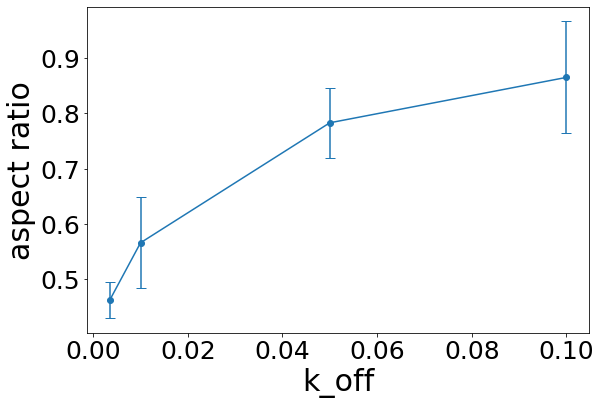

In [104]:
mean_values = np.mean(data_arr, axis=1)
std_values = np.std(data_arr, axis=1)

plt.figure(figsize = (9, 6))
plt.errorbar(k_offs, mean_values, yerr=std_values, fmt='o-', capsize=5)
plt.xlabel('k_off')
plt.ylabel('Aspect Ratio')
# plt.title('Mean and Standard Deviation of Aspect Ratio')
# plt.grid(True)
plt.xlabel("k_off", fontsize = 30)
plt.ylabel("aspect ratio", fontsize = 30)
plt.tick_params(axis = 'x', labelsize = 25)
plt.tick_params(axis = 'y', labelsize = 25)
plt.show()